# Machine Learning with Text Data

### Introduction

Natural Language Processing (or NLP) is ubiquitous and has multiple applications. A few examples include email classification into spam and ham, chatbots, AI agents, social media analysis, and classifying customer or employee feedback into Positive, Negative or Neutral.

In this guide, we will take up an extremely popular use case of NLP - building a supervised machine learning model on text data.

### Problem Statement

In this guide, we will take up the task of automating reviews in medicine. The medical literature is voluminous and rapidly changing, increasing the need for reviews. Often, such reviews are done manually, which is tedious and time-consuming. We will try to address this problem by building a text classification model which will automate the process.

The dataset nlpdata2.csv we will use comes from a Pubmed search, and contains 1748 observations and 3 variables, as described below:

    title - consists of the titles of papers retrieved

    abstract - consists of the abstracts of papers retrieved

    trial - variable indicating whether the paper is a clinical trial testing a drug therapy for cancer.
    class - like the variable 'trial', indicating whether the paper is a clinical trial (Yes) or not (No). This is the target variable and was added in the original data.

### Steps

Following are the steps we will follow in this guide.

Step 1 - Loading the required libraries and modules.

Step 2 - Loading the data and performing basic data checks.

Step 3 - Pre-processing the raw text and getting it ready for machine learning.

Step 4 - Creating the Training and Test datasets.

Step 5 - Converting text to word frequency vectors with TfidfVectorizer.

Step 6 - Create and fit the classifier.

Step 7 - Computing the evaluation metrics.

The following sections will cover these steps.

### Step 1 - Loading the Required Libraries and Modules

In [1]:
# Import required libraries

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.utils import shuffle


%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

### Step 2 - Loading the Data and Performing Basic Data Checks

The first line of code reads in the data as pandas data frame, while the second line prints the shape - 1,748 observations of 4 variables. The third line prints the first five observations.

In [3]:
df = pd.read_csv(r'F:\work in jupyter\NLP\datasets\nlpdata2.csv')

print(df.shape)

df.head()

(1748, 4)


,title,abstract,trial,class
0,Tetracosactrin vs. methylprednisolone in the p...,0.5 mg tetracosactrin is considered to be equi...,0,No
1,Cyclic combination chemotherapy for metastatic...,104 nonrandomized patients suffering from meta...,1,Yes
2,Reduced morbidity from skeletal metastases in ...,131 patients with osteolytic metastases from b...,0,No
3,Comparison of short-term and continuous chemot...,132 patients with advanced recurrent breast ca...,1,Yes
4,A randomised phase III cross-over study of tam...,139 peri- and postmenopausal women with advanc...,1,Yes


After loading the data, we will do basic data exploration. Let us check the distribution of the target class which can be done using barplot. The first line of code below groups the 'class' variables by counting the number of their occurrences. The second line displays the barplot.

It is evident that we have more occurrences of 'No' than 'Yes' in the target variable. Still, the good thing is that the difference is not significant and the data is relatively balanced.

The baseline accuracy is calculated in the third line of code, which comes out to be 56%. It is calculated as the number of times the majority class (i.e., 'No') appears in the target variable, divided by the total number of observations.

The baseline accuracy is important but often ignored in machine learning. It sets the benchmark in terms of minimum accuracy which the model should achieve.

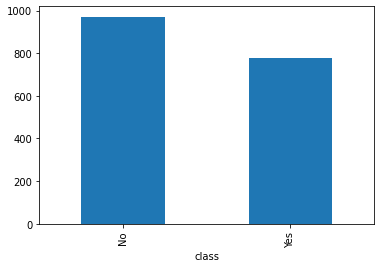

0.5554919908466819


In [4]:
df.groupby('class').abstract.count().plot.bar(ylim=0)

plt.show()

print(971/1748) #Baseline accuracy

### Step 3 – Pre-processing the Raw Text and Getting It Ready for Machine Learning

Now, we are ready to build our text classifier. However, this is where things begin to get trickier in NLP. The data we have is in raw text which by itself, cannot be used as features. So, we will have to pre-process the text.

The common pre-processing steps are:

Removing punctuation - the rule of thumb is to remove everything that is not in the form x,y,z.

Removing stopwords - these are unhelpful words like 'the', 'is', 'at'. These are not helpful because the frequency of such stopwords is high in the corpus, but they don't help in differentiating the target classes. The removal of Stopwords also reduces the data size.

Conversion to lower case - words like 'Clinical' and 'clinical' need to be considered as one word. Hence, these are converted to lowercase.

Stemming - the goal of stemming is to reduce the number of inflectional forms of words appearing in the text. This causes words such as “argue”, "argued", "arguing", "argues" to be reduced to their common stem “argu”. This helps in decreasing the size of the vocabulary space. There are many ways to perform Stemming, the popular one being the “Porter Stemmer” method by Martin Porter.

For completing the above-mentioned steps, we will have to load the nltk package, which is done in the first line of code below. The second line downloads the list of 'stopwords' in the nltk package.

In [5]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sadnan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

With nltk package loaded and ready to use, we will perform the pre-processing tasks. The first two lines of code below imports the stopwords and the PorterStemmer modules, respectively.

The third line imports the regular expressions library, ‘re’, which is a powerful python package for text parsing. 

The fourth to sixth lines of code does the text pre-processing discussed above.




In [6]:
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer

import re


stemmer = PorterStemmer()

words = stopwords.words("english")


df['processedtext'] = df['abstract'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

We will now look at the pre-processed data set that has a new column 'processedtext'.

In [7]:
print(df.shape)

df.head(10)

(1748, 5)


,title,abstract,trial,class,processedtext
0,Tetracosactrin vs. methylprednisolone in the p...,0.5 mg tetracosactrin is considered to be equi...,0,No,mg tetracosactrin consid equival mg methylpred...
1,Cyclic combination chemotherapy for metastatic...,104 nonrandomized patients suffering from meta...,1,Yes,nonrandom patient suffer metastat breast cance...
2,Reduced morbidity from skeletal metastases in ...,131 patients with osteolytic metastases from b...,0,No,patient osteolyt metastas breast cancer random...
3,Comparison of short-term and continuous chemot...,132 patients with advanced recurrent breast ca...,1,Yes,patient advanc recurr breast cancer treat four...
4,A randomised phase III cross-over study of tam...,139 peri- and postmenopausal women with advanc...,1,Yes,peri postmenopaus women advanc recurr breast c...
5,17ss-Hydroxysteroid dehydrogenase type 1 as pr...,17ss-Hydroxysteroid dehydrogenases (17HSDs) ar...,0,No,ss hydroxysteroid dehydrogenas hsd involv loca...
6,Vindesine-mitoxantrone (VM) versus vindesine-4...,182 patients with metastatic breast cancer wer...,1,Yes,patient metastat breast cancer random v mg v m...
7,Phase I study of L-asparaginase (NSC 109229).,22 patients received intravenously infused L-a...,0,No,patient receiv intraven infus l asparaginas es...
8,Adjuvant chemotherapy in the treatment of brea...,248 patients with locally radically treated ea...,1,Yes,patient local radic treat earli breast cancer ...
9,Scalp cooling has no place in the prevention o...,35 patients were studied to determine the effe...,0,No,patient studi determin effect scalp hypothermi...


### Step 4 - Creating the Training and Test Datasets

The first line of code below imports the module for creating training and test data sets. The second line creates an array of the target variable, called 'target'.

The third line creates the training (X_train, y_train) and test set (X-test, y_test) arrays. It keeps 30% of the data for testing the model. The 'random_state' argument ensures that the results are reproducible.

The fourth line prints the shape of the overall, training and test dataset, respectively.

In [8]:
from sklearn.model_selection import train_test_split


target = df['class']


X_train, X_test, y_train, y_test = train_test_split(df['processedtext'], target, test_size=0.30, random_state=100)


print(df.shape); print(X_train.shape); print(X_test.shape)

(1748, 5)
(1223,)
(525,)


### Step 5 - Converting Text to Word Frequency Vectors with TfidfVectorizer.

We have processed the text, but we need to convert it to word frequency vectors for building machine learning models. There are several ways to do this, such as using CountVectorizer and HashingVectorizer, but the TfidfVectorizer is the most popular one.

TF-IDF is an acronym that stands for 'Term Frequency-Inverse Document Frequency'. It is used as a weighting factor in text mining applications.

Term Frequency (TF): This summarizes the normalized Term Frequency within a document.

Inverse Document Frequency (IDF): This reduces the weight of terms that appear a lot across documents. In simple terms, TF-IDF attempts to highlight important words which are frequent in a document but not across documents. We will work on creating TF-IDF vectors for our documents.

The first line of code below imports the TfidfVectorizer from 'sklearn.feature_extraction.text' module. The second line initializes the TfidfVectorizer object, called 'vectorizer_tfidf'.

The third line fits and transforms the training data. The fourth line of code transforms the test data, while the fifth line prints the first 10 features.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)


train_tfIdf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))


test_tfIdf = vectorizer_tfidf.transform(X_test.values.astype('U'))


print(vectorizer_tfidf.get_feature_names()[:10])

['aa', 'aacr', 'aag', 'aastrom', 'ab', 'abandon', 'abc', 'abcb', 'abcsg', 'abdomen']


Let's look at the shape of the transformed TF-IDF train and test datasets. The following line of code performs this task.

In [10]:
print(train_tfIdf.shape); print(test_tfIdf.shape)

(1223, 5602)
(525, 5602)


### Step 6 - Create and Fit the Classifier.

Now, we will build the text classification model. The algorithm we will choose is the Naive Bayes Classifier, which is commonly used for text classification problems, as it is based on probability. It is simple and effective in answering questions such as "Given a particular term in the document, what is the likely chance (probability) that it belongs to the particular class?"

We start by importing the necessary modules that is done in the first two lines of code below. The third line creates a Multinomial Naive Bayes classifier, called 'nb_classifier'. The fourth line of code fits the classifier on the training data.

Finally, our model is trained and it is ready to generate predictions on the unseen data. This is performed in the fifth line of code, while the sixth line prints the predicted class for the first 10 records in the test data.

In [11]:
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics


nb_classifier = MultinomialNB()


nb_classifier.fit(train_tfIdf, y_train)


pred2 = nb_classifier.predict(test_tfIdf) 

print(pred2[:10])

['No' 'Yes' 'Yes' 'No' 'No' 'Yes' 'Yes' 'No' 'No' 'Yes']


### Step 7 - Computing the Evaluation Metrics

We are now ready to evaluate the performance of our model on test data. Using the 'metrics.accuracy_score’ function, we compute the accuracy in the first line of code below and print the result using the second line of code. We see that the accuracy is 86.5%, which is a good score.

We can also calculate the accuracy through confusion metrics. The third line of code below creates the confusion metrics, where the 'labels' argument is used to specify the target class labels ('Yes' or 'No' in our case). The fourth line prints the confusion metrics. 

In [12]:
# Calculate the accuracy score: score

accuracy_tfidf = metrics.accuracy_score(y_test, pred2)

print(accuracy_tfidf)


Conf_metrics_tfidf = metrics.confusion_matrix(y_test, pred2, labels=['Yes', 'No'])

print(Conf_metrics_tfidf)

0.8647619047619047
[[211  28]
 [ 43 243]]


Using the main diagonal results on the confusion matrix as the true labels, we can calculate the accuracy, which is 86.5%.

In [13]:
(211+243)/(239+286)

0.8647619047619047

### Evaluation of the Naïve Bayes Model

At the beginning of the guide, we established the baseline accuracy of 55.5%. Our Naive Bayes model is conveniently beating this baseline model by achieving the accuracy score of 86.5%. This also sets a new benchmark for any new algorithm or model refinements. We will try out the Random Forest Algorithm to see if it improves our result.

### Building Random Forest Classifier

The first two lines of code below import the necessary modules. The third line creates a Random Forest Classifier, while the fourth line fits the classifier on the training data.

In [14]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix


classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 100)


classifier.fit(train_tfIdf, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=100)

Once the model training is done, we use the model to generate predictions on the test data, which is done in the first line of code below. The second line prints the predicted class for the first 10 records in the test data. The third and fourth lines of code calculates and prints the accuracy score, respectively. We see that the accuracy dropped to 78.6%.

In [15]:
predRF = classifier.predict(test_tfIdf) 

print(predRF[:10])


# Calculate the accuracy score

accuracy_RF = metrics.accuracy_score(y_test, predRF)

print(accuracy_RF)


Conf_metrics_RF = metrics.confusion_matrix(y_test, predRF, labels=['Yes', 'No'])

print(Conf_metrics_RF)

['No' 'Yes' 'Yes' 'No' 'No' 'Yes' 'Yes' 'No' 'No' 'Yes']
0.7866666666666666
[[187  52]
 [ 60 226]]


### Conclusion

In this guide, you have learned the fundamentals of text cleaning and pre-processing, and building and evaluating text classification models using Naive Bayes and Random Forest Algorithms. The performance of the models is summarized below:

    Baseline Model Accuracy - 56%

    Accuracy achieved by Naive Bayes Classifier - 86.5%
    Accuracy achieved by Random Forest Classifier - 78.7%

We can see that both the algorithms easily beat the baseline accuracy, but the Naive Bayes Classifier outperforms the Random Forest Classifier with approximately 87% accuracy. 